In [19]:
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

from keras.layers import Input,BatchNormalization
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, UpSampling2D
from keras.datasets import cifar10
from keras.optimizers import Adam
from keras import backend as K
from keras import initializers

K.set_image_dim_ordering('tf')   # very important command setting the dimension 
# For 2D data (e.g. image), "tf" assumes (rows, cols, channels) 
#while "th" assumes (channels, rows, cols).
# The dimensionality has been set at 100 for consistency with other GAN implementations. 
# But 10 works better here
latent_dim = 100
# Load cifar data
(X_train, y_train), (X_valid, y_valid) = cifar10.load_data()


print(X_train.shape)
# Use Adam as the Optimizer
adam = Adam(lr=0.0002, beta_1=0.5)

(50000, 32, 32, 3)


In [22]:
xtrain=(X_train.astype('float32'))/255
xvalid=(X_valid.astype('float32'))/255

In [23]:
xtrain.shape

(50000, 32, 32, 3)

In [27]:
generator = Sequential()

# Transforms the input into a 8 × 8 128-channel feature map
generator.add(Dense(128*8*8, input_dim=latent_dim))

generator.add(LeakyReLU(0.2))
generator.add(Reshape((8,8,128)))
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Conv2D(64, kernel_size=(5, 5), padding='same'))
generator.add(LeakyReLU(0.2))
generator.add(UpSampling2D(size=(2, 2)))

# Produces a 28 × 28 1-channel feature map (shape of a MNIST image)
generator.add(Conv2D(3, kernel_size=(5, 5), padding='same', activation='sigmoid'))
print(generator.summary()) 
generator.compile(loss='binary_crossentropy', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 8192)              827392    
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 8192)              0         
_________________________________________________________________
reshape_4 (Reshape)          (None, 8, 8, 128)         0         
_________________________________________________________________
up_sampling2d_7 (UpSampling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 16, 16, 64)        204864    
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
up_sampling2d_8 (UpSampling2 (None, 32, 32, 64)        0         
__________

In [28]:
discriminator = Sequential()
discriminator.add(Conv2D(64, kernel_size=(5, 5), strides=(2, 2), padding='same', 
                         input_shape=(32,32,3), kernel_initializer=initializers.RandomNormal(stddev=0.02)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Conv2D(128, kernel_size=(5, 5), strides=(2, 2), padding='same'))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Dropout(0.3))
discriminator.add(Flatten())
discriminator.add(Dense(1, activation='sigmoid'))
print(discriminator.summary())
discriminator.compile(loss='binary_crossentropy', optimizer=adam)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 16, 16, 64)        4864      
_________________________________________________________________
leaky_re_lu_15 (LeakyReLU)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 8, 8, 128)         204928    
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 8, 8, 128)         0         
_________________________________________________________________
flatten_4 (Flatten)          (None, 8192)              0         
__________

In [29]:


discriminator.trainable = False
ganInput = Input(shape=(latent_dim,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=adam)



In [30]:
gan.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_8 (Sequential)    (None, 32, 32, 3)         1037059   
_________________________________________________________________
sequential_9 (Sequential)    (None, 1)                 217985    
Total params: 1,255,044
Trainable params: 1,037,059
Non-trainable params: 217,985
_________________________________________________________________


In [31]:
dLosses = []
gLosses = []

# Plot the loss from each batch
def plotLoss(epoch):
    plt.figure(figsize=(10, 8))
    plt.plot(dLosses, label='Discriminitive loss')
    plt.plot(gLosses, label='Generative loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    #plt.savefig('images/dcgan_loss_epoch_%d.png' % epoch)

# Create a wall of generated MNIST images
def plotGeneratedImages(epoch, examples=100, dim=(10, 10), figsize=(10, 10)):
    noise = np.random.normal(0, 1, size=[examples, latent_dim])
    generatedImages = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generatedImages.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generatedImages[i,0])
        plt.axis('off')
    plt.tight_layout()

In [36]:
epochs = 30
batchSize = 128
batchCount = X_train.shape[0] // batchSize

print('Epochs:', epochs)
print('Batch size:', batchSize)
print('Batches per epoch:', batchCount)

for e in range(1, epochs+1):
    print('-'*15, 'Epoch %d' % e, '-'*15)
    for i in tqdm(range(int(batchCount))):
        # Get a random set of input noise and images
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        imageBatch = xtrain[np.random.randint(0, xtrain.shape[0], size=batchSize)]
        #randomly select images from Mnist data
        # Generate fake MNIST images
        generatedImages = generator.predict(noise)
        X = np.concatenate([imageBatch, generatedImages])

        # Labels for generated and real data
        yDis = np.zeros(2*batchSize)
        # One-sided label smoothing
        yDis[:batchSize] = 0.9

        # Train discriminator
        discriminator.trainable = True
        dloss = discriminator.train_on_batch(X, yDis)

        # Train generator
        noise = np.random.normal(0, 1, size=[batchSize, latent_dim])
        yGen = np.ones(batchSize)
        discriminator.trainable = False
        gloss = gan.train_on_batch(noise, yGen)

    # Store loss of most recent batch from this epoch
    dLosses.append(dloss)
    gLosses.append(gloss)

    

  0%|          | 1/390 [00:00<00:52,  7.44it/s]

Epochs: 30
Batch size: 128
Batches per epoch: 390
--------------- Epoch 1 ---------------


  1%|          | 2/390 [00:00<00:37, 10.23it/s]

--------------- Epoch 2 ---------------


  1%|          | 2/390 [00:00<00:37, 10.27it/s]

--------------- Epoch 3 ---------------


  1%|          | 2/390 [00:00<00:37, 10.29it/s]

--------------- Epoch 4 ---------------


  1%|          | 2/390 [00:00<00:37, 10.31it/s]

--------------- Epoch 5 ---------------


  1%|          | 2/390 [00:00<00:37, 10.31it/s]

--------------- Epoch 6 ---------------


  1%|          | 2/390 [00:00<00:37, 10.35it/s]

--------------- Epoch 7 ---------------


  1%|          | 2/390 [00:00<00:38, 10.11it/s]

--------------- Epoch 8 ---------------


  1%|          | 2/390 [00:00<00:37, 10.36it/s]

--------------- Epoch 9 ---------------


  1%|          | 2/390 [00:00<00:37, 10.31it/s]

--------------- Epoch 10 ---------------


  1%|          | 2/390 [00:00<00:38, 10.21it/s]

--------------- Epoch 11 ---------------


  1%|          | 2/390 [00:00<00:37, 10.25it/s]

--------------- Epoch 12 ---------------


  1%|          | 2/390 [00:00<00:38, 10.19it/s]

--------------- Epoch 13 ---------------


  1%|          | 2/390 [00:00<00:38, 10.18it/s]

--------------- Epoch 14 ---------------


  1%|          | 2/390 [00:00<00:38, 10.16it/s]

--------------- Epoch 15 ---------------


  1%|          | 2/390 [00:00<00:37, 10.24it/s]

--------------- Epoch 16 ---------------


  1%|          | 2/390 [00:00<00:37, 10.22it/s]

--------------- Epoch 17 ---------------


  1%|          | 2/390 [00:00<00:37, 10.28it/s]

--------------- Epoch 18 ---------------


  1%|          | 2/390 [00:00<00:37, 10.32it/s]

--------------- Epoch 19 ---------------


  0%|          | 1/390 [00:00<00:39,  9.80it/s]

--------------- Epoch 20 ---------------


  1%|          | 2/390 [00:00<00:37, 10.25it/s]

--------------- Epoch 21 ---------------


  1%|          | 2/390 [00:00<00:37, 10.23it/s]

--------------- Epoch 22 ---------------


  1%|          | 2/390 [00:00<00:37, 10.35it/s]

--------------- Epoch 23 ---------------


  1%|          | 2/390 [00:00<00:38, 10.21it/s]

--------------- Epoch 24 ---------------


  1%|          | 2/390 [00:00<00:37, 10.33it/s]

--------------- Epoch 25 ---------------


  1%|          | 2/390 [00:00<00:37, 10.28it/s]

--------------- Epoch 26 ---------------


  1%|          | 2/390 [00:00<00:37, 10.30it/s]

--------------- Epoch 27 ---------------


  1%|          | 2/390 [00:00<00:38, 10.13it/s]

--------------- Epoch 28 ---------------


  1%|          | 2/390 [00:00<00:37, 10.32it/s]

--------------- Epoch 29 ---------------


  1%|          | 2/390 [00:00<00:37, 10.33it/s]

--------------- Epoch 30 ---------------


100%|██████████| 390/390 [00:38<00:00, 10.22it/s]


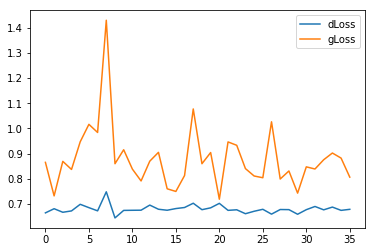

In [40]:
plt.plot(dLosses,label='dLoss')
plt.plot(gLosses,label='gLoss')
plt.legend()


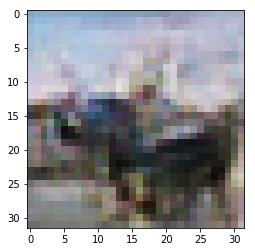

In [41]:
plt.imshow(generatedImages[0])

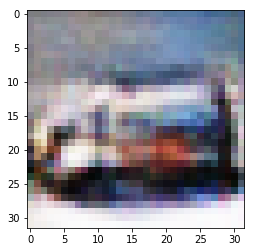

In [42]:
plt.imshow(generatedImages[1])

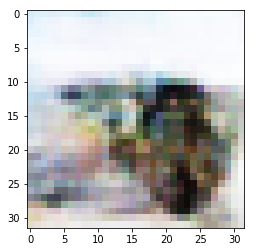

In [43]:
plt.imshow(generatedImages[2])

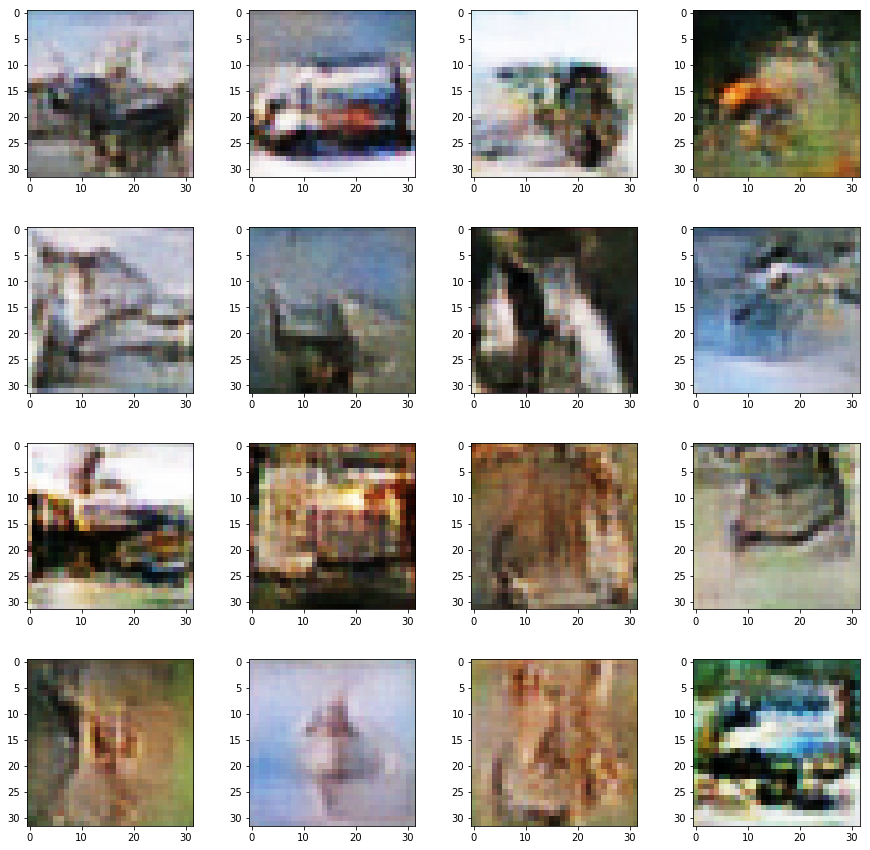

In [47]:
fig, axes = plt.subplots(4, 4,figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i,ax in enumerate(axes.flat):
    ax.imshow(generatedImages[i])


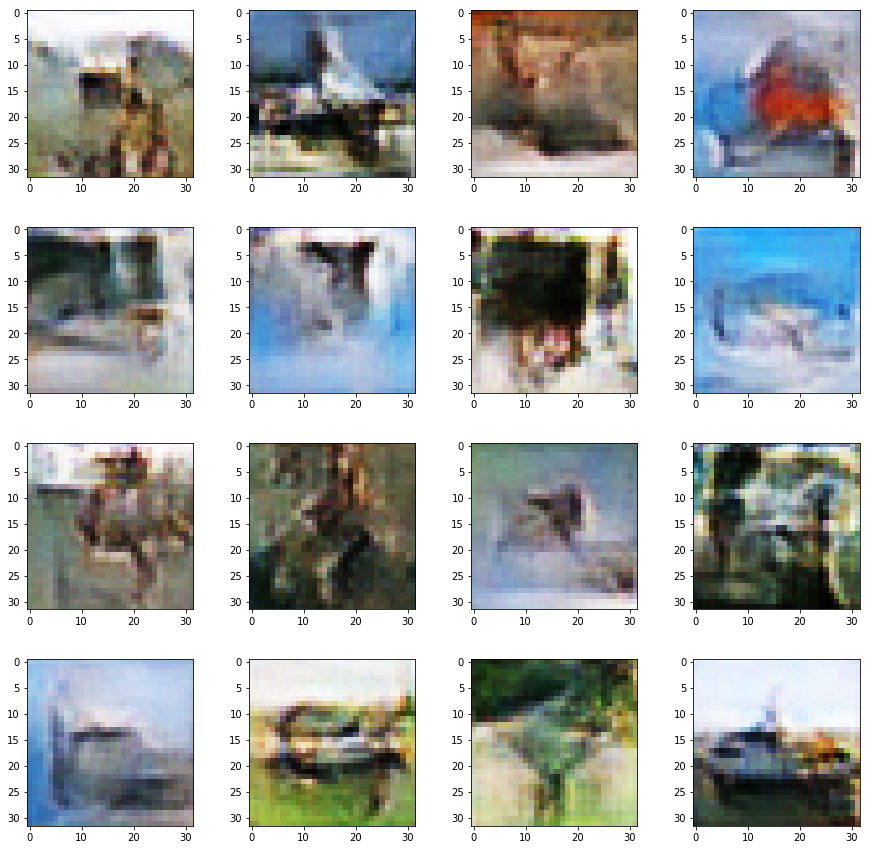

In [50]:
noise=np.random.normal(0,1,[16,100])
generatedImages1=generator.predict(noise)
fig, axes = plt.subplots(4, 4,figsize=(15,15))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i,ax in enumerate(axes.flat):
    ax.imshow(generatedImages1[i])

In [ ]:
--->>Done<<--